# GPTChallenge: diagnóstico a partir de HCE

Vamos a trabajar con el corpus CodEsp (textos de historial clínico etiquetados con sus códigos CIE-10 Diagnóstico)

In [1]:
# !unzip DataChallenge.zip

In [2]:
import pandas as pd
import os, re
import numpy as np

pd.options.display.max_colwidth = None

In [3]:
#los códigos están en un TSV con un código por línea
train_diag = pd.read_csv("data/train/train.tsv", sep="\t", header=None, names=["archivo", "codigo"])
train_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8316 entries, 0 to 8315
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  8316 non-null   object
 1   codigo   8316 non-null   object
dtypes: object(2)
memory usage: 130.1+ KB


In [4]:
train_diag['codigo'].value_counts()

codigo
r52        163
r69        150
r50.9      142
i10        116
r59.9       95
          ... 
d37.030      1
c79.71       1
g25.0        1
l76.3        1
n81.2        1
Name: count, Length: 2194, dtype: int64

In [5]:
#cogemos la categoría superior de cada código y las agrupamos
train_diag['cat'] = train_diag['codigo'].str.extract(r'(\w\d\d)')
print(train_diag['cat'].value_counts())
train_diag['cat'].nunique()

cat
r52    163
r10    163
r59    160
r69    150
r50    144
      ... 
c31      1
d62      1
s53      1
s34      1
n81      1
Name: count, Length: 918, dtype: int64


918

In [6]:
categories=train_diag['cat'].value_counts()[:10]
top_categorias = categories.index.to_list()
print(top_categorias)

['r52', 'r10', 'r59', 'r69', 'r50', 'r60', 'i10', 'r11', 'n28', 'd49']


In [7]:
#seleccionamos sólo las etiquetas de este subconjunto
train_diag = train_diag[np.isin(train_diag['cat'], top_categorias)]

In [8]:
#cargamos los dos conjuntos de train
path = 'data/train/text_files/'

corpus = []
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    with open(os.path.join(path, f), encoding="utf8") as text:
        texto = text.read()
    #buscamos códigos
    file = f[:-4]
    codigos = train_diag.query('archivo==@file')['cat'].to_list()
    codigos = list(set(codigos))
    if codigos:
        corpus.append({
            'archivo': file,
            'texto': texto,
            'codigos': codigos
        })

df_train = pd.DataFrame(corpus).set_index('archivo')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, S0004-06142005000700014-1 to S2340-98942015000100005-1
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   texto    562 non-null    object
 1   codigos  562 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


In [9]:
df_train.sample(3)

,texto,codigos
archivo,,
S1130-05582008000500009-1,"Paciente varón de 64 años de edad que acudió al Servicio de Cirugía Oral y Maxilofacial del Hospital Universitario Central de Asturias por presentar un carcinoma de células escamosas que afectaba al borde lingual, la pared lateral orofaríngea, el área amigdalar y el hemipaladar blando izquierdos. Presentaba asimismo grandes adenopatías metastásicas en los ejes vasculares y en las regiones submaxilares de ambos lados del cuello.\nEn un primer tiempo quirúrgico se realizó la resección del tumor, un vaciamiento cervical radical clásico izquierdo y una reconstrucción del defecto con un colgajo microvascularizado fasciocutáneo anterolateral de muslo. Tres semanas más tarde se procedió a realizar un vaciamiento cervical radical clásico derecho. Dada la magnitud de la cirugía y en previsión de posibles complicaciones postoperatorias, en la primera intervención se practicó también una traqueotomía reglada electiva, empleando el colgajo de Björk como modo de apertura de la tráquea. La traqueotomía se mantuvo hasta varios días después de la segunda intervención, produciéndose un cierre espontáneo del traqueostoma tras decanular al paciente y liberar la unión del colgajo traqueal a la piel.\n\nPosteriormente el paciente recibió tratamiento radioterápico complementario sobre la cavidad oral, la orofarínge y los niveles ganglionares cervicales I al VI.\nEn una TC cervicotorácica de control, solicitado 4 meses tras la cirugía, se apreció la existencia de una pequeña masa compatible con proceso neoplásico en el lóbulo medio pulmonar derecho, motivo por el que fue remitido al Servicio de Neumología. Se realizó entonces una broncoscopia, en la cual se observó un hilo de sutura en la luz de la tráquea, de color negro, de unos 2,5 cm de longitud, insertado por uno de sus extremos en la pared traqueal anterior. Se intentó retirar, pero al comprobar que estaba fijado firmemente, y para evitar posibles desgarros en la pared de la tráquea, se optó por no hacerlo. Finalmente, la masa pulmonar resultó ser de naturaleza inflamatoria y se resolvió espontáneamente.\n\nEn relación con el hilo de sutura traqueal, la única sintomatología referida por el paciente era, ocasionalmente, sensación de cuerpo extraño, sin llegar a producir tos ni disnea.\n\n",[r59]
S1130-05582011000300005-1,"Paciente de 56 años de edad, tratado por cáncer de borde lingual izquierdo mediante glosectomía izquierda y linfadenectomía cervical izquierda, pT4N2bM0 borde quirúrgico positivo, recibiendo radioquimioterapia adyuvante concurrentes (cisplatino, radioterapia conformada tridimensional) (66Gy lecho tumoral, 54Gy cadenas cervicales) que finaliza en marzo 2006. En noviembre 2007 (18 meses) objetivamos una masa laterocervical derecha, nivel II, de 4cm y 29mm en TC. Estudio de extensión negativo. Anatomía patológica: carcinoma. Considerado irresecable en comité de Tumores de Cabeza y Cuello (CTCC) por dudas de infiltración del músculo esternocleidomastoideo, decidimos quimioterapia (cisplatino seis ciclos) y reevaluación. En mayo de 2008 RNM cervical objetiva remisión parcial (24mm). Valorado en CTCC, decidimos linfadenectomía cervical funcional modificada derecha con resección de vena yugular y nervio espinal englobado por masa tumoral, seguida de HDRBT intersticial (junio de 2008), colocando los vectores en el acto quirúrgico. Tras extirpación total, el lecho tumoral, y órganos de riesgo (carótida, plexo braquial) fueron identificados por el cirujano y el oncólogo. Utilizamos implante monoplano con cinco tubos plásticos (separados 1cm minimizando riesgo de toxicidad vascular) y botones confort (fijación catéter-piel) Nucletron®. Empleamos para simulación terapéutica cortes (5mm) de TC helicoidal. La anatomía patológica fue de metástasis de carcinoma escamoso pobremente diferenciado en 4 de 7 de ganglios resecados, todos con infiltración extraganglionar. El volumen de planificación de HDRBT se definió a 5mm desde el centro del cat

## Cargar los textos del conjunto de test

In [10]:
#los códigos están en un TSV con un código por línea
test_diag = pd.read_csv("data/test/test.tsv", sep="\t", header=None, names=['archivo'])
test_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  192 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


In [11]:
path = 'data/test/text_files/'

# Lista para almacenar los textos y sus códigos correspondientes
corpus = []

# Itera sobre los archivos de texto en el directorio
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    with open(os.path.join(path, f), encoding="utf8") as text:
        texto = text.read()

    # Extrae el código del nombre del archivo
    file = f[:-4]

    # Agrega el texto al corpus
    corpus.append({
        'archivo': file,
        'texto': texto
    })

# Crea un DataFrame a partir del corpus
df_test = pd.DataFrame(corpus).set_index('archivo')

In [12]:
df_test.sample(3)

,texto
archivo,
S0212-71992004001100007-1,"Paciente varón de 60 años de edad, con prótesis mitral metálica tipo Björk-Shilley y anuloplastia tricuspídea 20 años atrás por valvulopatía reumática, fibrilación auricular crónica (FAC), HTA, insuficiencia cardiaca congestiva (ICC) con un Grado Funcional NYHA I/IV. Recibía tratamiento con acenocumarol. Ingresa en nuestro servicio por cuadro de fiebre, escalofríos, y empeoramiento de su disnea habitual, apareciendo ortopnea y edemas en MMII. La exploración clínica era compatible con una ICC (venas yugulares ingurgitadas, pulso arritmico a 100 lpm, ritmo de galope, crepitantes basales bilaterales pulmonares, hepatomegalia de 2 traveses con reflejo hepatoyugular positivo y edemas pretibiales con fóvea en los MMII). En la analítica presentaba una hemoglobina de 12,4 g/L, leucocitos 17.810/ml, con un 87% de neutrófilos, estando el resto de los parámetros habituales dentro de la normalidad. La radiografía de tórax mostraba signos de ICC. Se realizaron hemocultivos seriados en los que se aisló de forma persistente Neisseria Sicca, por lo que se inició tratamiento con Penicilina G sódica intravenosa 24 millones de unidades en perfusión contínua y Gentamicina 80 mg I.V. cada 8 horas (2 primeras semanas), quedando el paciente afebril al tercer día de comenzar el tratamiento. En el transcurso del ingreso aparecieron unas lesiones rojizas y dolorosas en los pulpejos de los dedos de ambas manos compatibles con fenómenos vasculíticos, realizándose, por tanto, el diagnóstico de Endocarditis Infecciosa (EI) según los criterios clínicos de Durack (4). La Ecocardiografia Transtorácica (ETT) y Transesofágica (ETE) demostró una prótesis mitral normofuncionante y ausencia de vegetaciones. Al 9º día de tratamiento el paciente presentó un episodio brusco de pérdida de fuerza en hemicuerpo izquierdo, visualizándose en TAC craneal 3 imagénes hiperdensas a nivel temporalparietal y occipital de ambos hemisferios compatibles con focos hemorrágicos. En ese momento en I.N.R. era de 2,45, a pesar de lo cual, la anticoagulación fue suspendida. Cuatro días después, y la tras estabilización del paciente, se decidió reiniciar anticoagulación con heparina sódica iv completándose 6 semanas de tratamiento antibiótico y heparina. En el TAC cerebral de control tras el tratamiento, persistía el hematoma occipitoparietal, habiendo desaparecido los otros focos hemorrágicos. Ante éstos hallazgos y la posibilidad de resangrado, el paciente fue dado de alta con bemiparina 10.000 U.I. subcutánea una vez al día, durante 3 meses, tras los cuales se realizó nuevo estudio ecocardiográfico y TAC craneal que demostraron la normalidad de la válvula mitral y la práctica resolución del hematoma cerebral, por lo que nuevamente se inició anticoagulación oral con acenocumarol, encontrándose a los tres meses de la misma, asintomático.\n"
S0004-06142007000900012-1,"Mujer de 67 años de edad con antecedentes personales de apendicectomía, hernia discal y de hiato, fractura de tibia y peroné, así como cólico nefrítico derecho que acude a consulta de urología para revisión. En el estudio ecográfico, se observa una neoformación sólida en riñón derecho de 5 cm.; se realiza TAC en el que se describe una masa a nivel cortical de riñón derecho, de aproximadamente 5 cm, de bordes externos lobulados, que no parece afectar al espacio perirrenal, no observándose adenopatías, ni dilatación de vía renal excretora. Con el diagnóstico de probable hipernefroma se realiza nefrectomía radical derecha mediante laparoscopia.\n\nEn el estudio macroscópico se describe una neoformación cortical de 5 cm de diámetro máximo, bien delimitada, pero no encapsulada, que deforma la superficie cortical sin atravesarla, con una superficie de corte de coloración amarillenta con áreas de aspecto hemorrágicas y áreas quísticas.\nEn el estudio microscópico la neoformación está constituida por estructuras acinares tapizadas por pequeñas células cuboidales uniformes, con escaso citop

## Binarizar las etiquetas

In [13]:
# para entrenar un clasificador multi-etiqueta generamos una matriz binaria de las etiquetas
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['codigos'])

#Guardamos las clases utilizadas en el conjunto de train
clases = mlb.classes_
num_classes = clases.shape
print(num_classes[0])

10


## Procesamiento del lenguaje natural

In [14]:
import utils

df_train_clean = utils.clean_corpus(df_train, column_name='texto')
df_test_clean = utils.clean_corpus(df_test, column_name='texto')

In [15]:
# Hacerlo solo la primera vez
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carpe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

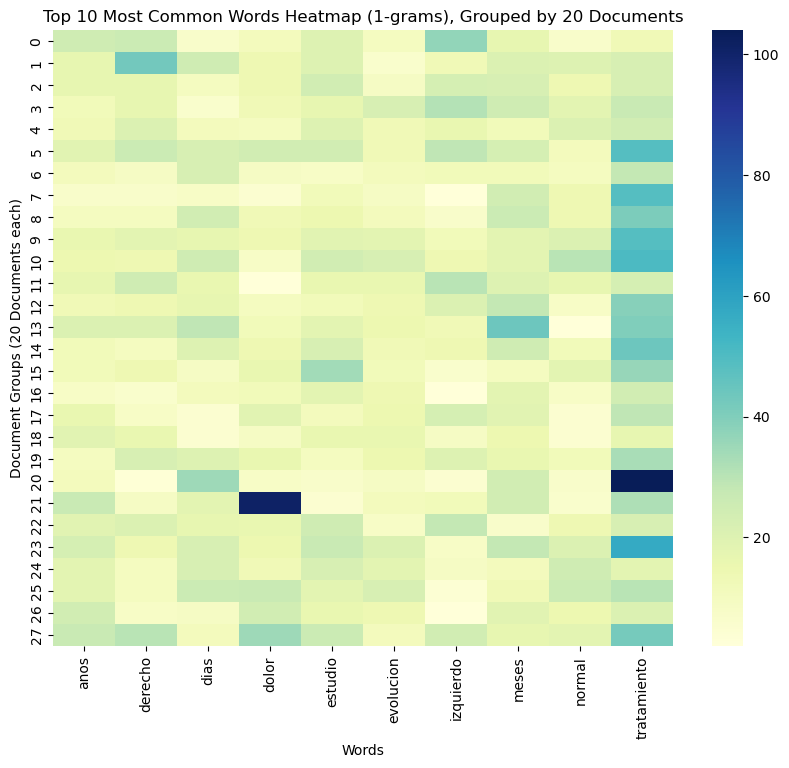

In [16]:
#Hay un vocabulario demasiado grande como para representarlo en una BoW
utils.plot_bow_heatmap(df_train_clean, column_name='texto', n_words=10, n_grams=1)

## Modelos

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [18]:
# Vectorizar el texto utilizando TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(df_train_clean['texto'])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)

In [19]:
model = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])

In [20]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.04424778761061947
Validation F1-score: 0.2734375


In [21]:
from xgboost import XGBClassifier

In [22]:
model2 = Pipeline([
    ('clf', OneVsRestClassifier(XGBClassifier()))
])

In [23]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model2.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model2.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.4336283185840708
Validation F1-score: 0.8115942028985508


In [24]:
from sklearn.ensemble import AdaBoostClassifier

In [25]:
model3 = Pipeline([
    ('clf', OneVsRestClassifier(AdaBoostClassifier()))
])

In [26]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model3.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model3.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.4424778761061947
Validation F1-score: 0.815347721822542


### Búsqueda de hiperparámetros

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [28]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score

# Ejemplo de datos de clasificación multietiqueta
X, y = make_multilabel_classification(n_samples=1000, n_features=20, n_classes=5, n_labels=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(AdaBoostClassifier()))
])

# Definir los hiperparámetros a buscar
param_grid = {
    'clf__estimator__n_estimators': [370, 375, 380],
    'clf__estimator__learning_rate': [0.01, 0.011]
}

# Definir el objeto GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average='micro'),
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Ajustar el GridSearchCV a los datos de entrenamiento
grid_search.fit(X_train_split, y_train_split)

# Obtener los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)



Fitting 3 folds for each of 6 candidates, totalling 18 fits
Mejores hiperparámetros: {'clf__estimator__learning_rate': 0.01, 'clf__estimator__n_estimators': 370}
Validation Accuracy: 0.4778761061946903
Validation F1-score: 0.8226221079691517


Mejores hiperparámetros: {'clf__estimator__learning_rate': 0.01, 'clf__estimator__n_estimators': 370}

## Guardar predicciones de Test

In [29]:
# Vectorizar el texto utilizando TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_test_vectorized = vectorizer.fit_transform(df_test_clean['texto'])

In [30]:
predictions = best_model.predict(X_test_vectorized)

In [43]:
predictions.shape

(250, 10)

In [44]:
df_test_clean.shape

(250, 1)

In [31]:
import pandas as pd

# Supongamos que ya tienes tus predicciones
predictions = best_model.predict(X_test_vectorized)

# Si las predicciones tienen múltiples columnas, asigna nombres de columna adecuados
num_columns = predictions.shape[1]
assert num_columns == 10, "El número de columnas en predictions no coincide con el número de nombres de columna proporcionados"

# Nombres de las columnas, excepto 'archivo'
column_names = top_categorias

# Convierte las predicciones en un DataFrame de pandas
df_predictions = pd.DataFrame(predictions, columns=column_names)

# Añade la columna 'archivo' de df_test al DataFrame de predicciones
df_predictions['archivo'] = df_test.index

print(df_predictions.head())

# Reordena las columnas para que 'archivo' sea la primera
columnas = ['archivo'] + [col for col in df_predictions.columns if col != 'archivo']
df_predictions = df_predictions[columnas]

# Guarda el DataFrame resultante en un archivo CSV
df_predictions.to_csv('grupo_09.csv', index=False)

   r52  r10  r59  r69  r50  r60  i10  r11  n28  d49                    archivo
0    0    0    0    0    0    0    0    1    0    0  S0004-06142005000500011-1
1    0    0    0    0    0    0    0    0    0    0  S0004-06142005000900014-1
2    0    0    0    0    0    0    0    0    0    0  S0004-06142006000100010-1
3    0    0    0    0    0    0    0    0    0    0  S0004-06142006000500012-1
4    0    0    0    0    0    0    0    0    0    0  S0004-06142006000600014-1
